## Task 1: Value Iteration $G^*$

In [46]:
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_enviroment, action_space, transition_function, probabilistic_transition_function, state_consistency_check

Visualization

Text(0, 0.5, 'X')

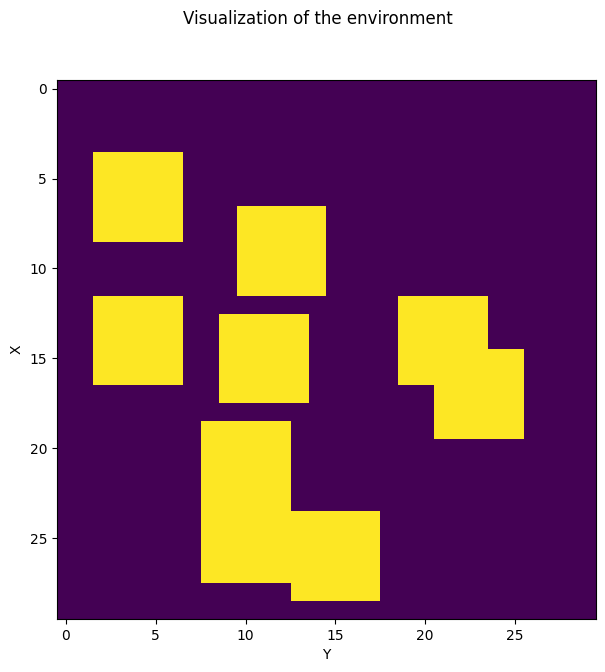

In [47]:
data = np.load("data_ps3.npz")
environment = data['environment']

plt.figure(figsize = (7, 7))
plt.suptitle("Visualization of the environment")

plt.imshow(environment)
plt.xlabel('Y')
plt.ylabel('X')


###  1A. Enumerate the action space. The coordinates of actions are $u = (row, column)$.

In [48]:
action_space

[(-1, 0), (0, -1), (1, 0), (0, 1)]

In [49]:
action_names = ['left', 'down', 'up', 'right']
for i in range(len(action_space)):
    print(action_names[i], action_space[i])
    
actions = dict(zip(action_space, action_names))  
actions  

left (-1, 0)
down (0, -1)
up (1, 0)
right (0, 1)


{(-1, 0): 'left', (0, -1): 'down', (1, 0): 'up', (0, 1): 'right'}

### 1B. Formulate the optimal cost-to-go $G^*$ in recursive form

$G_k^* = min_{u_k}(l(x_k, u_k) + G_{k+1}^*(f(x_k, u_k)))$

### 1C. Implement the VI algorithm for infinite length sequences.

In [201]:
X_initial = (10, 6)
X_goal = (5, 29)

In [202]:
def implement_value_iteration(env, goal, max_iter=100, action_space=action_space):
    action_cost = 1
    num_rows, num_cols = env.shape

    # Initialize the value function matrix
    V = np.full((num_rows, num_cols), fill_value=np.inf)
    V[goal] = 0

    iteration_counter = 0
    convergence_flag = True

    while convergence_flag:
        if iteration_counter >= max_iter:
            break

        iteration_counter += 1
        convergence_flag = False

        # Update the value function
        for row in range(num_rows):
            for col in range(num_cols):
                if V[row, col] != np.inf:
                    current_state = (row, col)

                    for action in action_space:
                        new_state, is_valid_action = transition_function(env, current_state, action)

                        if is_valid_action:
                            new_value = V[current_state] + action_cost
                            V[new_state] = min(V[new_state], new_value)
                            convergence_flag = True

    return V


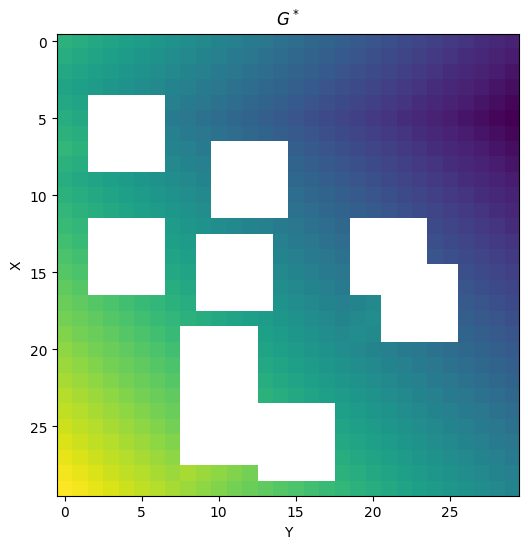

In [203]:
G_star = implement_value_iteration(environment, X_goal)

plt.figure(figsize=[6, 6])
plt.imshow(G_star)
plt.title(r'$G^*$')
plt.xlabel('Y')
plt.ylabel('X')
plt.show()

### 1D. (5 pts) Experiment with different number of iterations. Start with a 1 iteration VI, describe the results obtained and reason why.


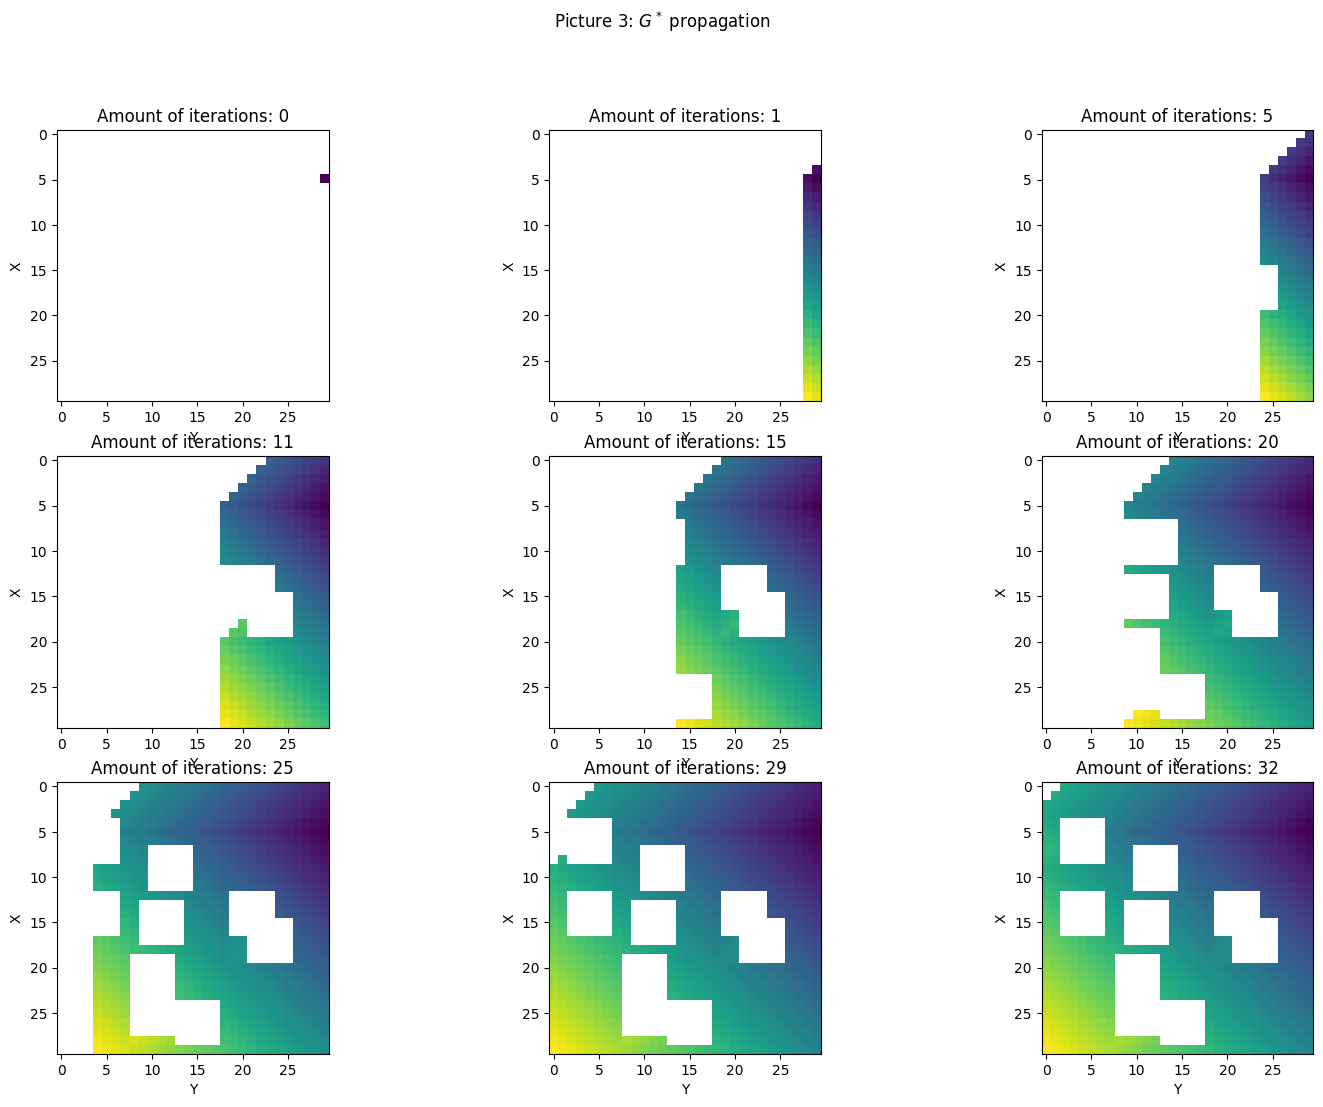

In [204]:
steps = [0, 1, 5, 11, 15, 20, 25, 29, 32]
G_iter = []
for step in steps:
    G_iter.append(implement_value_iteration(environment, X_goal, max_iter=step))

# Plot the Heatmap of the matrix
plt.figure(figsize=[18, 12])
plt.suptitle(r'Picture 3: $G^*$ propagation')

for i in range(len(steps)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(G_iter[i])
    plt.title(f'Amount of iterations: {steps[i]}')
    plt.xlabel('Y')
    plt.ylabel('X')

plt.show()

## Task 2: Calculate a plan with VI

### 2A.Formulate how to obtain the optimal policy $u^*$ from $G^*$

$u^* = arg_{u \in U(x)} min(l(x, u) + G^*(f(x, u)))$

From any random point in the specified environment, we have to pick the point(state) with the number that has the lowest value and move towards these numbers in order to get an optimal path.

### 2B. Implement an algorithm to obtain the optimal policy $u^*$ from $G^*$. This policy can be a table. To test this, start at an initial position and execute the result of your policy and the transition function until you reach the goal.

In [205]:
def implement_policy_VI(G, env=environment, actions=actions, action_space=action_space):
    policy = np.chararray(G.shape, itemsize=5)
    
    for x in range(G.shape[0]):
        for y in range(G.shape[1]):
            state = (x, y)
            
            for action in action_space:
                new_state, is_action = transition_function(env, state, action)
                
                if is_action:
                    if G[state] > G[new_state]:
                        
                        diff = tuple(np.array(new_state) - np.array(state))
                        policy[state] = actions[diff]
                        
                        # If we already changed the cell, then omit other actions
                        break
    return policy
policy = implement_policy_VI(G_star)

In [206]:
policy

chararray([[b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up'],
           [b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up'],
           [b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up'],
           [b'right', b'right', b'right', b'right', b'right', b'right',
            b'right', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            b'up', b'up', b'up', b'up', b'up', b'up', b'up', b'up',
            

In [207]:
def get_plan(X_init, X_goal, policy, actions=actions):
    # Invert actions dictionary
    inverted_actions = {name: coordinates for coordinates, name in actions.items()}
    
    plan = []

    state = X_init
    
    # While we have not reached the goal state
    while state != X_goal:
        plan.append(state)
        direction = policy[state].decode('ascii')
        coordinates = inverted_actions[direction]
        state = tuple(np.array(state) + np.array(coordinates))

    plan.append(X_goal)
    
    return plan

In [209]:
plan = get_plan(X_initial, X_goal, policy)

MovieWriter ffmpeg unavailable; using Pillow instead.


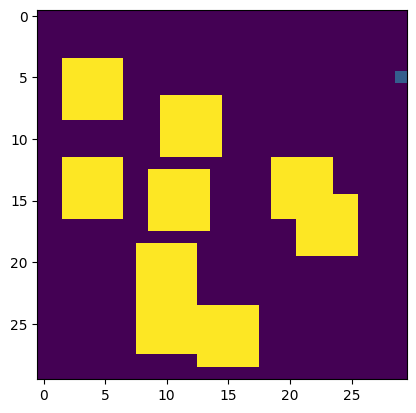

In [210]:
import matplotlib.animation as animation

fig = plt.figure()
imgs = []
for X in plan:
    im = plot_enviroment(environment, X, X_goal)
    plot = plt.imshow(im)
    imgs.append([plot])

ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('plan_vi.gif')
plt.show()

### 2C. Experiment with different parameters, such as starting points, the order of the states you use in VI(for loops) and the order of the actions. Explain your observations

MovieWriter ffmpeg unavailable; using Pillow instead.


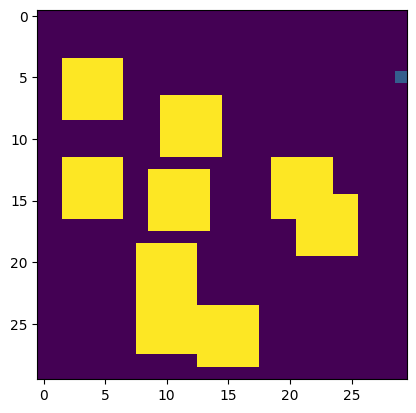

In [211]:
# Changing starting point
X_start = (0, 0)
plan_C_a = get_plan(X_start, X_goal, policy)

fig = plt.figure()
imgs = []
for X in plan_C_a:
    im = plot_enviroment(environment, X, X_goal)
    plot = plt.imshow(im)
    imgs.append([plot])

ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('plan_2C_1.gif')
plt.show()

Algorithm works well after changing starting point

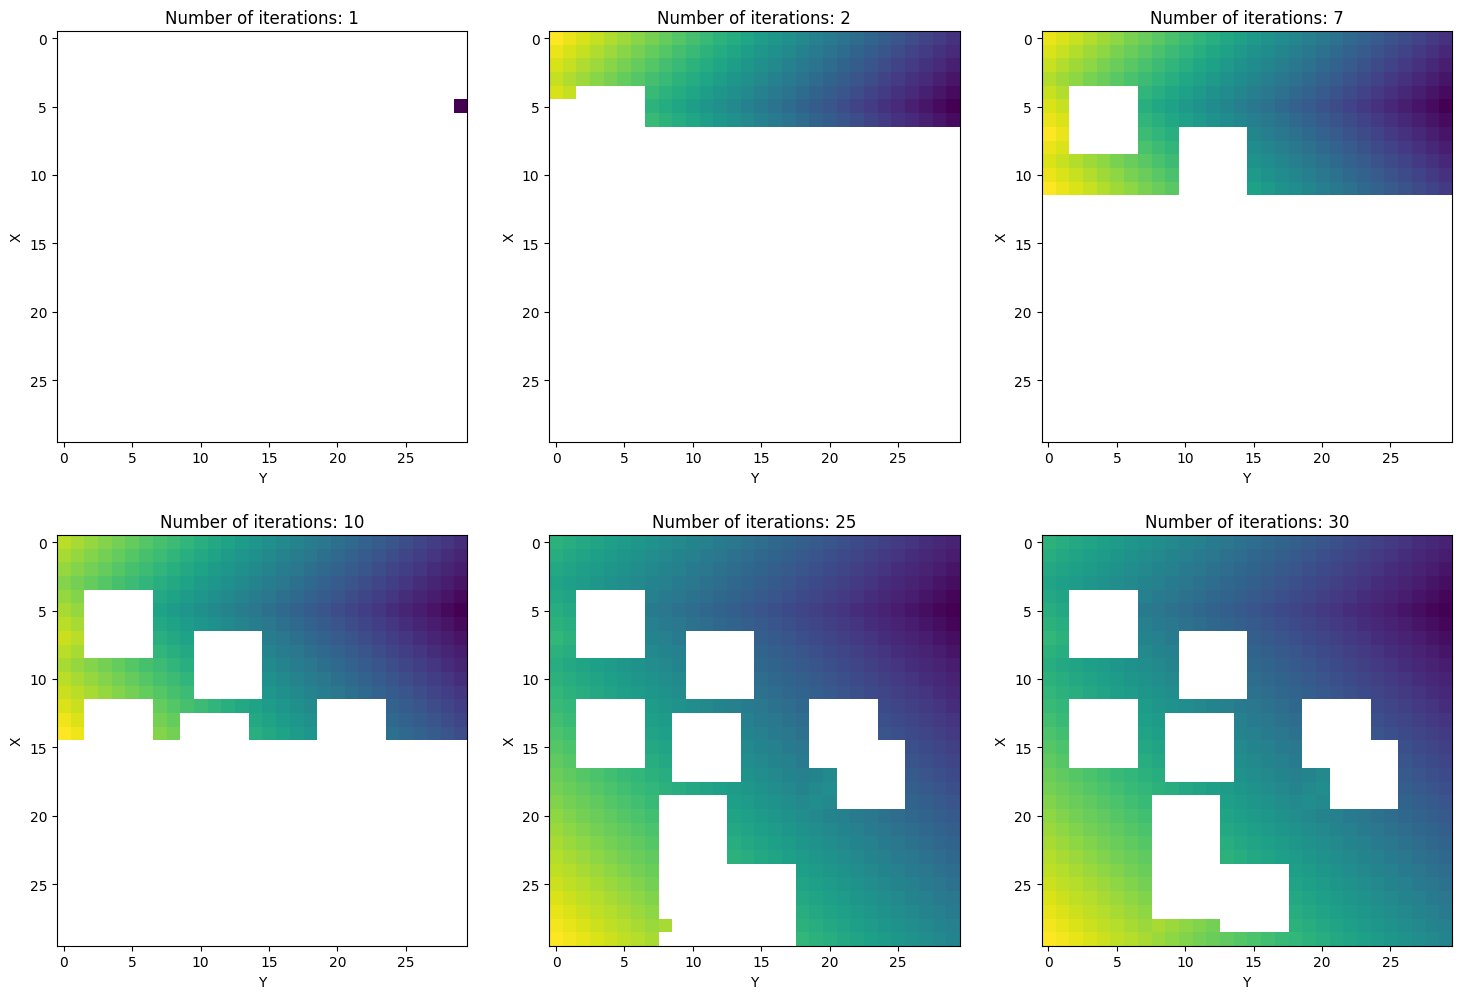

In [212]:
# Changing order of states for the value iteration algorithm
def implement_changed_value_iteration(env, goal, N=100):
    action_cost = 1
    G = np.zeros(env.shape)
    G[:] = np.inf
    G[goal] = 0

    counter = 0
    flag = True

    while flag == True:
        if flag == False:
            break
        counter += 1
        if counter == N:
            break
        flag = False

        for x in range(env.shape[0]-1, -1, -1):      # Here is the change
            for y in range(env.shape[1]-1, -1, -1):  # Here is the change
                if G[x, y] != np.inf:
                    state = (x, y)
                    for action in action_space:
                        new_state, is_action = transition_function(env, state, action)
                        if is_action:
                            G[new_state] = min(G[new_state], G[state] + action_cost)
                            flag = True
    return G

steps = [1, 2, 7, 10, 25, 30]
G_iter = []
for step in steps:
    G_iter.append(implement_changed_value_iteration(environment, X_goal, N=step))

plt.figure(figsize=[18, 12])

for i in range(len(steps)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(G_iter[i])
    plt.title(f'Number of iterations: {steps[i]}')
    plt.xlabel('Y')
    plt.ylabel('X')

plt.show()

Comment: a faster way to calculate cost-to-go matrix for the particular goal state

MovieWriter ffmpeg unavailable; using Pillow instead.


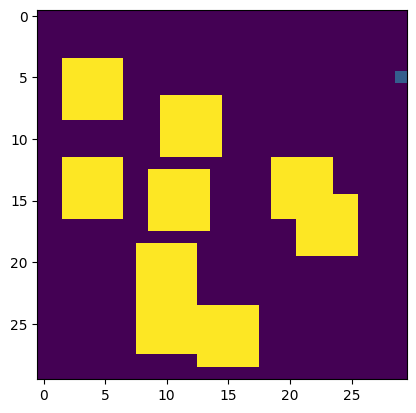

Original plan length: 29
Plan length with inverted actions: 29


In [213]:
inv_action_space = action_space[::-1]

policy_inv = implement_policy_VI(G_star, action_space=inv_action_space)

plan_C_2 = get_plan(X_initial, X_goal, policy_inv)

# Visualization of the algorithm
fig = plt.figure()
imgs = []
for X in plan_C_2:
    im = plot_enviroment(environment, X, X_goal)
    plot = plt.imshow(im)
    imgs.append([plot])

ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('plan_2C_2.gif')
plt.show()

print(f'Original plan length: {len(plan)}')
print(f'Plan length with inverted actions: {len(plan_C_2)}')

Comment: Policy was changed and hence the plan was changed but the plan length remains the same.

# Task 3. Markov decision process

The optimal value function \(v^*(x)\) is given by:

$ v^*(x) = \max_{u \in \mathcal{U}} \left( r(x, u) + \gamma \sum_{x'} P(x' \mid x, u) v^*(x') \right) $

- $ x $ is the current state,
- $ u $ is the action,
- $ \mathcal{U} $ is the set of possible actions,
- $ r(x, u) $ is the immediate reward for taking action \( u \) in state \( x \),
- $ P(x' \mid x, u) $ is the transition probability to reach state \( x' \) from state \( x \) by taking action \( u \),
- $ \gamma $ is the discount factor,
- $ v^*(x) $ is the optimal value function.


To obtain the greedy deterministic policy $ u^* = \pi_{\text{MDP}}(x) $ from the optimal value function $ v^*(x) $, we use the following rule:

$ \pi_{\text{MDP}}(x) = \arg\max_{u \in \mathcal{U}} \left( r(x, u) + \gamma \sum_{x'} P(x' \mid x, u) v^*(x') \right) $

This means that, for each state $ x $, the greedy policy selects the action $ u $ that maximizes the sum of the immediate reward and the discounted value of the next state.


### 3C. Same as in task 1, Implement the MDP until convergence of v∗ using the same criterion as in 1.C.

In [214]:
from utils import transition_function

In [223]:
def mdp(env, goal, gamma=0.99, max_num_of_iterations=100):
    # Initialize the value function
    V = np.zeros(env.shape)
    V[goal] = 1  # Set the goal state value to 1 as it has a reward

    for iteration in range(max_num_of_iterations):
        new_V = V.copy()

        # Iterate over all states in the grid
        for row in range(V.shape[0]):
            for column in range(V.shape[1]):
                current_state = (row, column)

                # Initialize the new value as negative infinity
                new_value = -np.inf

                # Iterate over all possible actions in the action space
                for action in action_space:
                    # Get the probabilistic transition information for the current action
                    transition_states, transition_probs = probabilistic_transition_function(
                        env, current_state, action
                    )

                    rewards = []
                    transition_states_values = []

                    # Calculate rewards and expected values for each possible transition state
                    for state in transition_states:
                        if not state_consistency_check(env, state):
                            rewards.append(-1)
                            transition_states_values.append(0)
                        elif state == goal:
                            rewards.append(1)
                            transition_states_values.append(V[state])
                        else:
                            rewards.append(0)
                            transition_states_values.append(V[state])

                    # Calculate the expected reward and expected value for the current action
                    current_reward_expectation = np.sum(
                        np.array(transition_probs) * np.array(rewards)
                    )
                    transition_value_expectation = np.sum(
                        np.array(transition_probs) * np.array(transition_states_values)
                    )

                    # Update the new value based on the current action
                    new_value = max(
                        new_value,
                        current_reward_expectation
                        + gamma * transition_value_expectation,
                    )

                # Update the new value function for the current state
                new_V[current_state] = new_value

        # Check for convergence using a small tolerance level
        if np.allclose(V, new_V, atol=1e-3):
            print(f"Converged after {iteration + 1} iterations")
            break

        # Update the value function for the next iteration
        V = new_V

    # Set the value of the goal state to the maximum value in the final value function
    V[goal] = np.max(V)

    return V


In [224]:
def policy_mdp(env, V):
    policy = {}
    for row in range(V.shape[0]):
        for column in range(V.shape[1]):
            current_state = (row, column)
            transition_state_values = np.array(
                [
                    V[transition_function(env, current_state, action)[0]]
                    for action in action_space
                ]
            )
            best_action_id = np.argmax(transition_state_values)
            policy[current_state] = action_space[best_action_id]
    return policy

In [225]:
V_opt = mdp(environment, X_goal)

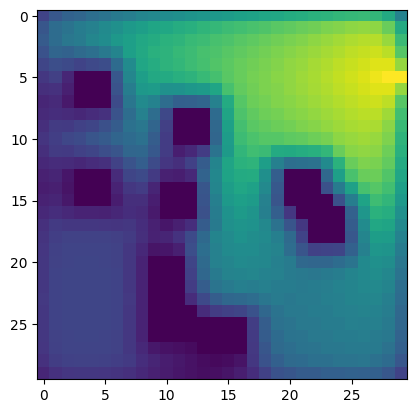

In [226]:
plt.imshow(V_opt)

In [227]:
policy = policy_mdp(environment, V_opt)

Goal reached in  29 iters


MovieWriter ffmpeg unavailable; using Pillow instead.


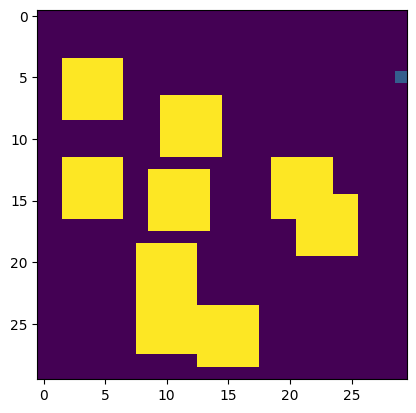

In [228]:
fig = plt.figure()
imgs = []
x = X_initial
for plan_iters in range(100):
    im = plot_enviroment(environment, x, X_goal)
    plot = plt.imshow(im)
    imgs.append([plot])
    x = transition_function(environment, x, policy[x])[0]

    if x == X_goal:
        print("Goal reached in ", plan_iters, "iters")
        break

im = plot_enviroment(environment, x, X_goal)
plot = plt.imshow(im)
imgs.append([plot])
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('plan_3_mdp.gif')
plt.show()

Value Iteration (Task 2B): This algorithm focuses on minimizing a cost function $G^*$
 . The primary objective is to find an optimal policy that minimizes the cumulative cost from each state to the goal. The resulting policy directs the agent along the path of least cost.

Markov Decision Process (Task 3D): In contrast, the MDP aims to maximize rewards through $V^*$
 . The optimal policy is derived based on maximizing the expected return from each state. This involves considering both immediate rewards and future returns. The resulting policy guides the agent to make decisions that maximize its cumulative reward.